  Binary data gives just two options where as multiclassdata is extended beyond 2 .

So , in order to introduce and update the concept of multiclass classifier , we
create some multi-class data with make_blobs(),turn the data into tensors (the default of make_blobs() is to use NumPy arrays),
split the data into training and test sets using train_test_split() and isualize the data.

tensor([[-8.4134,  6.9352],
        [-5.7665, -6.4312],
        [-6.0421, -6.7661],
        [ 3.9508,  0.6984],
        [ 4.2505, -0.2815]]) tensor([3, 2, 2, 1, 1])


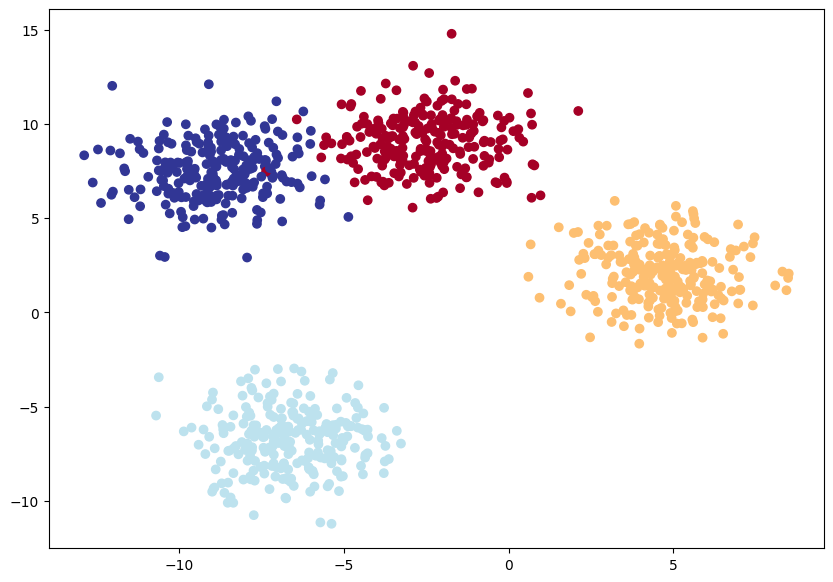

In [1]:
# Import dependencies
import torch
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.model_selection import train_test_split

# Set the hyperparameters for data creation
NUM_CLASSES = 4
NUM_FEATURES = 2
RANDOM_SEED = 42

# 1. Create multi-class data
X_blob, y_blob = make_blobs(n_samples=1000,
    n_features=NUM_FEATURES, # X features
    centers=NUM_CLASSES, # y labels
    cluster_std=1.5, # give the clusters a little shake up (try changing this to 1.0, the default)
    random_state=RANDOM_SEED
)

# 2. Turn data into tensors
X_blob = torch.from_numpy(X_blob).type(torch.float)
y_blob = torch.from_numpy(y_blob).type(torch.LongTensor)
print(X_blob[:5], y_blob[:5])

# 3. Split into train and test sets
X_blob_train, X_blob_test, y_blob_train, y_blob_test = train_test_split(X_blob,
    y_blob,
    test_size=0.2,
    random_state=RANDOM_SEED
)

# 4. Plot data
plt.figure(figsize=(10, 7))
plt.scatter(X_blob[:, 0], X_blob[:, 1], c=y_blob, cmap=plt.cm.RdYlBu);

In [3]:
# Create device agnostic code
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

Now , in order to build the multiclass model , we need to get the following input features , hidden layers and output layers . The big, bigger and biggest shift from binary classifier to multi-class classifier is that it needs more number of output , it is one neuron per class , instead just a single in binary .

In [4]:
from torch import nn

# Build model
class BlobModel(nn.Module):
    def __init__(self, input_features, output_features, hidden_units=8):
        """Initializes all required hyperparameters for a multi-class classification model.

        Args:
            input_features (int): Number of input features to the model.
            out_features (int): Number of output features of the model
              (how many classes there are).
            hidden_units (int): Number of hidden units between layers, default 8.
        """
        super().__init__()
        self.linear_layer_stack = nn.Sequential(
            nn.Linear(in_features=input_features, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            # nn.ReLU(), # <- does our dataset require non-linear layers? (try uncommenting and see if the results change)
            nn.Linear(in_features=hidden_units, out_features=output_features), # how many classes are there?
        )

    def forward(self, x):
        return self.linear_layer_stack(x)

# Create an instance of BlobModel and send it to the target device
model_4 = BlobModel(input_features=NUM_FEATURES,
                    output_features=NUM_CLASSES,
                    hidden_units=8).to(device)
model_4

BlobModel(
  (linear_layer_stack): Sequential(
    (0): Linear(in_features=2, out_features=8, bias=True)
    (1): Linear(in_features=8, out_features=8, bias=True)
    (2): Linear(in_features=8, out_features=4, bias=True)
  )
)

Despite there is no change in optimizer , we expect crossentropyloss in the loss function . This crossentropy loss is best suited to use with model outputs and labels . It handles the rest of things , so we do not need to worry about.


In [5]:
# Create loss and optimizer
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model_4.parameters(),
                            lr=0.1) # exercise: try changing the learning rate here and seeing what happens to the model's performance

Still , the model last ayer gives us value in num array (like [1.2, 0.3, 4.7]).
These are called logits.
However , We want probabilities (like 10% cat, 5% dog, 85% bird).


So, in order to convert this numerical array called logits in some sort of probabilistic value , we need softmax function , which takes logits (any numbers),turns them into probabilities thatare all positive,add up to 1 (or 100%).

Example (not exact numbers, just idea):

logits: [1.2, 0.3, 4.7]

softmax → maybe [0.1, 0.02, 0.88]

In [9]:
# Perform a single forward pass on the data (we'll need to put it to the target device for it to work)
model_4(X_blob_train.to(device))[:5]


tensor([[-0.1127, -0.1765,  0.3632, -0.0041],
        [ 0.7832,  0.6833,  0.2630, -0.3843],
        [-0.5223, -0.4975, -0.8765, -0.8834],
        [-0.2479, -0.2547, -0.5422, -0.7008],
        [ 0.6199,  0.5356,  0.1223, -0.4453]], grad_fn=<SliceBackward0>)

In [10]:
# How many elements in a single prediction sample?
model_4(X_blob_train.to(device))[0].shape, NUM_CLASSES

(torch.Size([4]), 4)

In [11]:
# Make prediction logits with model
y_logits = model_4(X_blob_test.to(device))

# Perform softmax calculation on logits across dimension 1 to get prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)
print(y_logits[:5])
print(y_pred_probs[:5])

tensor([[ 0.0059, -0.0654,  0.3982, -0.0148],
        [ 0.8127,  0.7333, -0.1258, -0.7126],
        [-0.5280, -0.5123, -0.7105, -0.7455],
        [-0.2302, -0.2793,  0.1984, -0.1000],
        [ 0.7196,  0.6142,  0.4163, -0.2376]], grad_fn=<SliceBackward0>)
tensor([[0.2277, 0.2121, 0.3371, 0.2231],
        [0.3949, 0.3647, 0.1545, 0.0859],
        [0.2737, 0.2780, 0.2280, 0.2202],
        [0.2162, 0.2058, 0.3318, 0.2462],
        [0.3309, 0.2978, 0.2443, 0.1271]], grad_fn=<SliceBackward0>)


In [12]:
# Sum the first sample output of the softmax activation function
torch.sum(y_pred_probs[0])

tensor(1., grad_fn=<SumBackward0>)

In [13]:
# Which class does the model think is *most* likely at the index 0 sample?
print(y_pred_probs[0])
print(torch.argmax(y_pred_probs[0]))

tensor([0.2277, 0.2121, 0.3371, 0.2231], grad_fn=<SelectBackward0>)
tensor(2)


Upto now, we illustrated the concept of softmax too .
Lets move to training and testing looop. The only difference is that we'll be adjusting the steps to turn the model outputs (logits) to prediction probabilities (using the softmax activation function) and then to prediction labels (by taking the argmax of the output of the softmax activation function).

Let's train the model for epochs=100 and evaluate


In [15]:
# Calculate accuracy (a classification metric)
def accuracy_fn(y_true, y_pred):
    correct = torch.eq(y_true, y_pred).sum().item() # torch.eq() calculates where two tensors are equal
    acc = (correct / len(y_pred)) * 100
    return acc

In [16]:
# Fit the model
torch.manual_seed(42)

# Set number of epochs
epochs = 100

# Put data to target device
X_blob_train, y_blob_train = X_blob_train.to(device), y_blob_train.to(device)
X_blob_test, y_blob_test = X_blob_test.to(device), y_blob_test.to(device)

for epoch in range(epochs):
    ### Training
    model_4.train()

    # 1. Forward pass
    y_logits = model_4(X_blob_train) # model outputs raw logits
    y_pred = torch.softmax(y_logits, dim=1).argmax(dim=1) # go from logits -> prediction probabilities -> prediction labels
    # print(y_logits)
    # 2. Calculate loss and accuracy
    loss = loss_fn(y_logits, y_blob_train)
    acc = accuracy_fn(y_true=y_blob_train,
                      y_pred=y_pred)

    # 3. Optimizer zero grad
    optimizer.zero_grad()

    # 4. Loss backwards
    loss.backward()

    # 5. Optimizer step
    optimizer.step()

    ### Testing
    model_4.eval()
    with torch.inference_mode():
      # 1. Forward pass
      test_logits = model_4(X_blob_test)
      test_pred = torch.softmax(test_logits, dim=1).argmax(dim=1)
      # 2. Calculate test loss and accuracy
      test_loss = loss_fn(test_logits, y_blob_test)
      test_acc = accuracy_fn(y_true=y_blob_test,
                             y_pred=test_pred)

    # Print out what's happening
    if epoch % 10 == 0:
        print(f"Epoch: {epoch} | Loss: {loss:.5f}, Acc: {acc:.2f}% | Test Loss: {test_loss:.5f}, Test Acc: {test_acc:.2f}%")

Epoch: 0 | Loss: 1.67977, Acc: 25.75% | Test Loss: 0.72740, Test Acc: 81.50%
Epoch: 10 | Loss: 0.17375, Acc: 99.00% | Test Loss: 0.15529, Test Acc: 99.00%
Epoch: 20 | Loss: 0.09241, Acc: 99.00% | Test Loss: 0.08337, Test Acc: 99.50%
Epoch: 30 | Loss: 0.06646, Acc: 98.88% | Test Loss: 0.05856, Test Acc: 99.50%
Epoch: 40 | Loss: 0.05429, Acc: 99.00% | Test Loss: 0.04649, Test Acc: 99.50%
Epoch: 50 | Loss: 0.04737, Acc: 99.00% | Test Loss: 0.03946, Test Acc: 99.50%
Epoch: 60 | Loss: 0.04297, Acc: 99.00% | Test Loss: 0.03490, Test Acc: 99.50%
Epoch: 70 | Loss: 0.03996, Acc: 99.00% | Test Loss: 0.03171, Test Acc: 99.50%
Epoch: 80 | Loss: 0.03777, Acc: 99.00% | Test Loss: 0.02936, Test Acc: 99.50%
Epoch: 90 | Loss: 0.03613, Acc: 99.00% | Test Loss: 0.02756, Test Acc: 99.50%


seems good test accuracy , but what about the real time ?

In [17]:
# Make predictions
model_4.eval()
with torch.inference_mode():
    y_logits = model_4(X_blob_test)

# View the first 10 predictions
y_logits[:10]

tensor([[  8.2229,  13.7763,  -8.6433,  -4.6894],
        [  3.4139, -12.4697,   1.8938,   9.1003],
        [-14.6255, -21.3821,  13.7941,   5.4444],
        [  3.3140,   8.7109,  -4.5904,  -4.0512],
        [ 12.5822,   7.9389,  -9.0536,   1.1368],
        [  3.5924, -15.5522,   2.7543,  11.0977],
        [-14.4323, -17.8868,  12.6177,   3.3806],
        [  9.8440,   2.4145,  -5.9602,   3.1622],
        [-16.0244, -27.6533,  16.4386,   8.6123],
        [ 10.6349,   4.3456,  -6.9572,   2.3696]])

why not turn this logitis into proability

In [18]:
# Turn predicted logits in prediction probabilities
y_pred_probs = torch.softmax(y_logits, dim=1)

# Turn prediction probabilities into prediction labels
y_preds = y_pred_probs.argmax(dim=1)

# Compare first 10 model preds and test labels
print(f"Predictions: {y_preds[:10]}\nLabels: {y_blob_test[:10]}")
print(f"Test accuracy: {accuracy_fn(y_true=y_blob_test, y_pred=y_preds)}%")

Predictions: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Labels: tensor([1, 3, 2, 1, 0, 3, 2, 0, 2, 0])
Test accuracy: 99.5%


Visualizing our decisons

In [21]:
import requests
from pathlib import Path

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

from helper_functions import plot_predictions, plot_decision_boundary

helper_functions.py already exists, skipping download


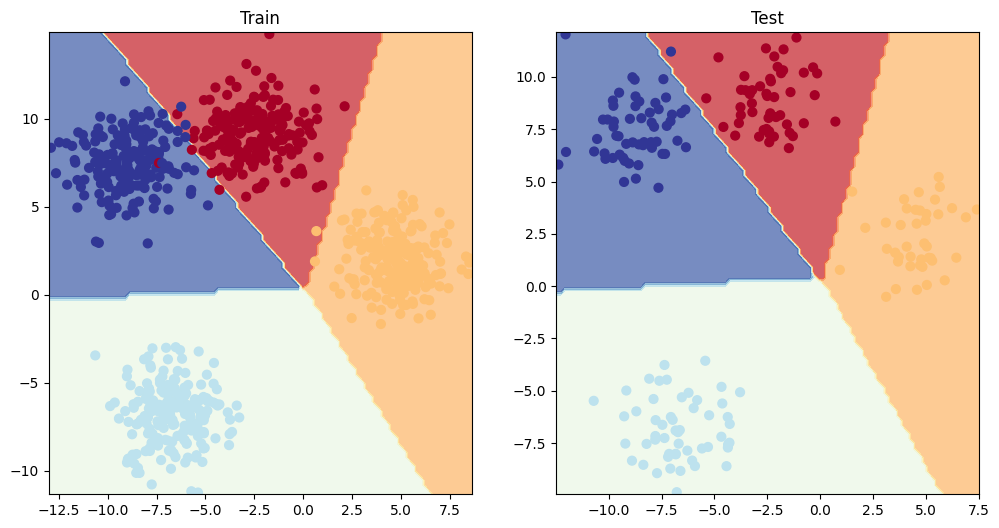

In [22]:
plt.figure(figsize=(12, 6))
plt.subplot(1, 2, 1)
plt.title("Train")
plot_decision_boundary(model_4, X_blob_train, y_blob_train)
plt.subplot(1, 2, 2)
plt.title("Test")
plot_decision_boundary(model_4, X_blob_test, y_blob_test)